# Descrição do problema

Queriamos desenvolver um modelo de classificação de popularidade utilizando as próprias playlists do usuário para dizer quais músicas de uma determinada playlist tem popularidades que variam dentro de uma determinada range.

Esse modelo foi pensado para entregar um valor numérico que será representado como a probabilidade daquela música ter uma popularidade `Alta`, `Média` e `Baixa`.

## Modelos utilizados

Dividimos os testes nesse notebook entre duas categorias. Modelos de Classificação e Modelos de Regressão.

> Os resultados de cada modelo pode se consultado no próprio notebook.

## Modelo escolhido

Para o propósito do trabalho, escolhemos utilizar modelos de Regressão, uma vez que queriamos calcular a probabilidade de popularidade de uma música dentro de uma playlist, e não apenas classificar se ela seria popular ou não.

Para isso, após os testes realizados, identificamos que o algoritmo de Random Forest Regressor teve o melhor match e resultado para nosso trabalho.





In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns


## Montando a partição do drive para carregar o dataset limpo já tratado.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dataset = pd.read_csv('/content/drive/My Drive/spotify_data_limpo.csv', encoding='latin1')

dataset.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,73,230666,False,0.676,0.461,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4
1,55,149610,False,0.420,0.166,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4
2,57,210826,False,0.438,0.359,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4
3,82,198853,False,0.618,0.443,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4
4,58,214240,False,0.688,0.481,6,-8.807,1,0.1050,0.2890,0.000000,0.1890,0.666,98.017,4


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54301 entries, 0 to 54300
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        54301 non-null  int64  
 1   duration_ms       54301 non-null  int64  
 2   explicit          54301 non-null  bool   
 3   danceability      54301 non-null  float64
 4   energy            54301 non-null  float64
 5   key               54301 non-null  int64  
 6   loudness          54301 non-null  float64
 7   mode              54301 non-null  int64  
 8   speechiness       54301 non-null  float64
 9   acousticness      54301 non-null  float64
 10  instrumentalness  54301 non-null  float64
 11  liveness          54301 non-null  float64
 12  valence           54301 non-null  float64
 13  tempo             54301 non-null  float64
 14  time_signature    54301 non-null  int64  
dtypes: bool(1), float64(9), int64(5)
memory usage: 5.9 MB


# Testando algoritmos de classificação

## Criando um novo dataset para classificações e incluindo a coluna de `popularity_category` para demarcar as popularidades

In [ ]:
classification_dataset = dataset.copy()
# Adiciona a coluna de popularity_category fazendo um cut na coluna de popularity e atribuindo labels definidas
classification_dataset['popularity_category'] = pd.cut(dataset['popularity'], bins=[0, 30, 60, 100], labels=['Low', 'Medium', 'High'])

print(classification_dataset.info())
classification_dataset.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54301 entries, 0 to 54300
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   popularity           54301 non-null  int64   
 1   duration_ms          54301 non-null  int64   
 2   explicit             54301 non-null  bool    
 3   danceability         54301 non-null  float64 
 4   energy               54301 non-null  float64 
 5   key                  54301 non-null  int64   
 6   loudness             54301 non-null  float64 
 7   mode                 54301 non-null  int64   
 8   speechiness          54301 non-null  float64 
 9   acousticness         54301 non-null  float64 
 10  instrumentalness     54301 non-null  float64 
 11  liveness             54301 non-null  float64 
 12  valence              54301 non-null  float64 
 13  tempo                54301 non-null  float64 
 14  time_signature       54301 non-null  int64   
 15  popularity_category

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,popularity_category
0,73,230666,False,0.676,0.461,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,High
1,55,149610,False,0.420,0.166,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,Medium
2,57,210826,False,0.438,0.359,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,Medium
3,82,198853,False,0.618,0.443,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,High
4,58,214240,False,0.688,0.481,6,-8.807,1,0.1050,0.2890,0.000000,0.1890,0.666,98.017,4,Medium


## Realizando o split entre dados de treino e test. As features utilizadas são todos os valores numéricos do dataset.

In [ ]:
features = classification_dataset.select_dtypes(include=['number']).columns

# Normalizando o dataset de treino e realizando a separação entre dados de teste e dados de treino.
X_train, X_test, Y_train, Y_test = train_test_split(classification_dataset.drop(['popularity_category'], axis=1), classification_dataset['popularity_category'], random_state=42, test_size=0.3, shuffle=True)

X_train.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
5218,53,226666,False,0.364,0.483,7,-8.220,1,0.0317,0.281000,0.000002,0.1130,0.700,102.967,4
12425,50,248571,False,0.660,0.729,6,-5.244,0,0.0529,0.000851,0.006790,0.1080,0.439,105.015,4
10646,57,283146,False,0.703,0.831,10,-7.225,0,0.0349,0.032800,0.008390,0.2180,0.949,103.573,4
517,57,259920,False,0.532,0.203,9,-8.524,0,0.0668,0.829000,0.000000,0.1080,0.543,89.646,4
5795,20,232200,False,0.519,0.280,10,-14.822,1,0.0366,0.444000,0.000014,0.0878,0.254,112.040,4


## Realizando um histograma para entender as features do dataset.

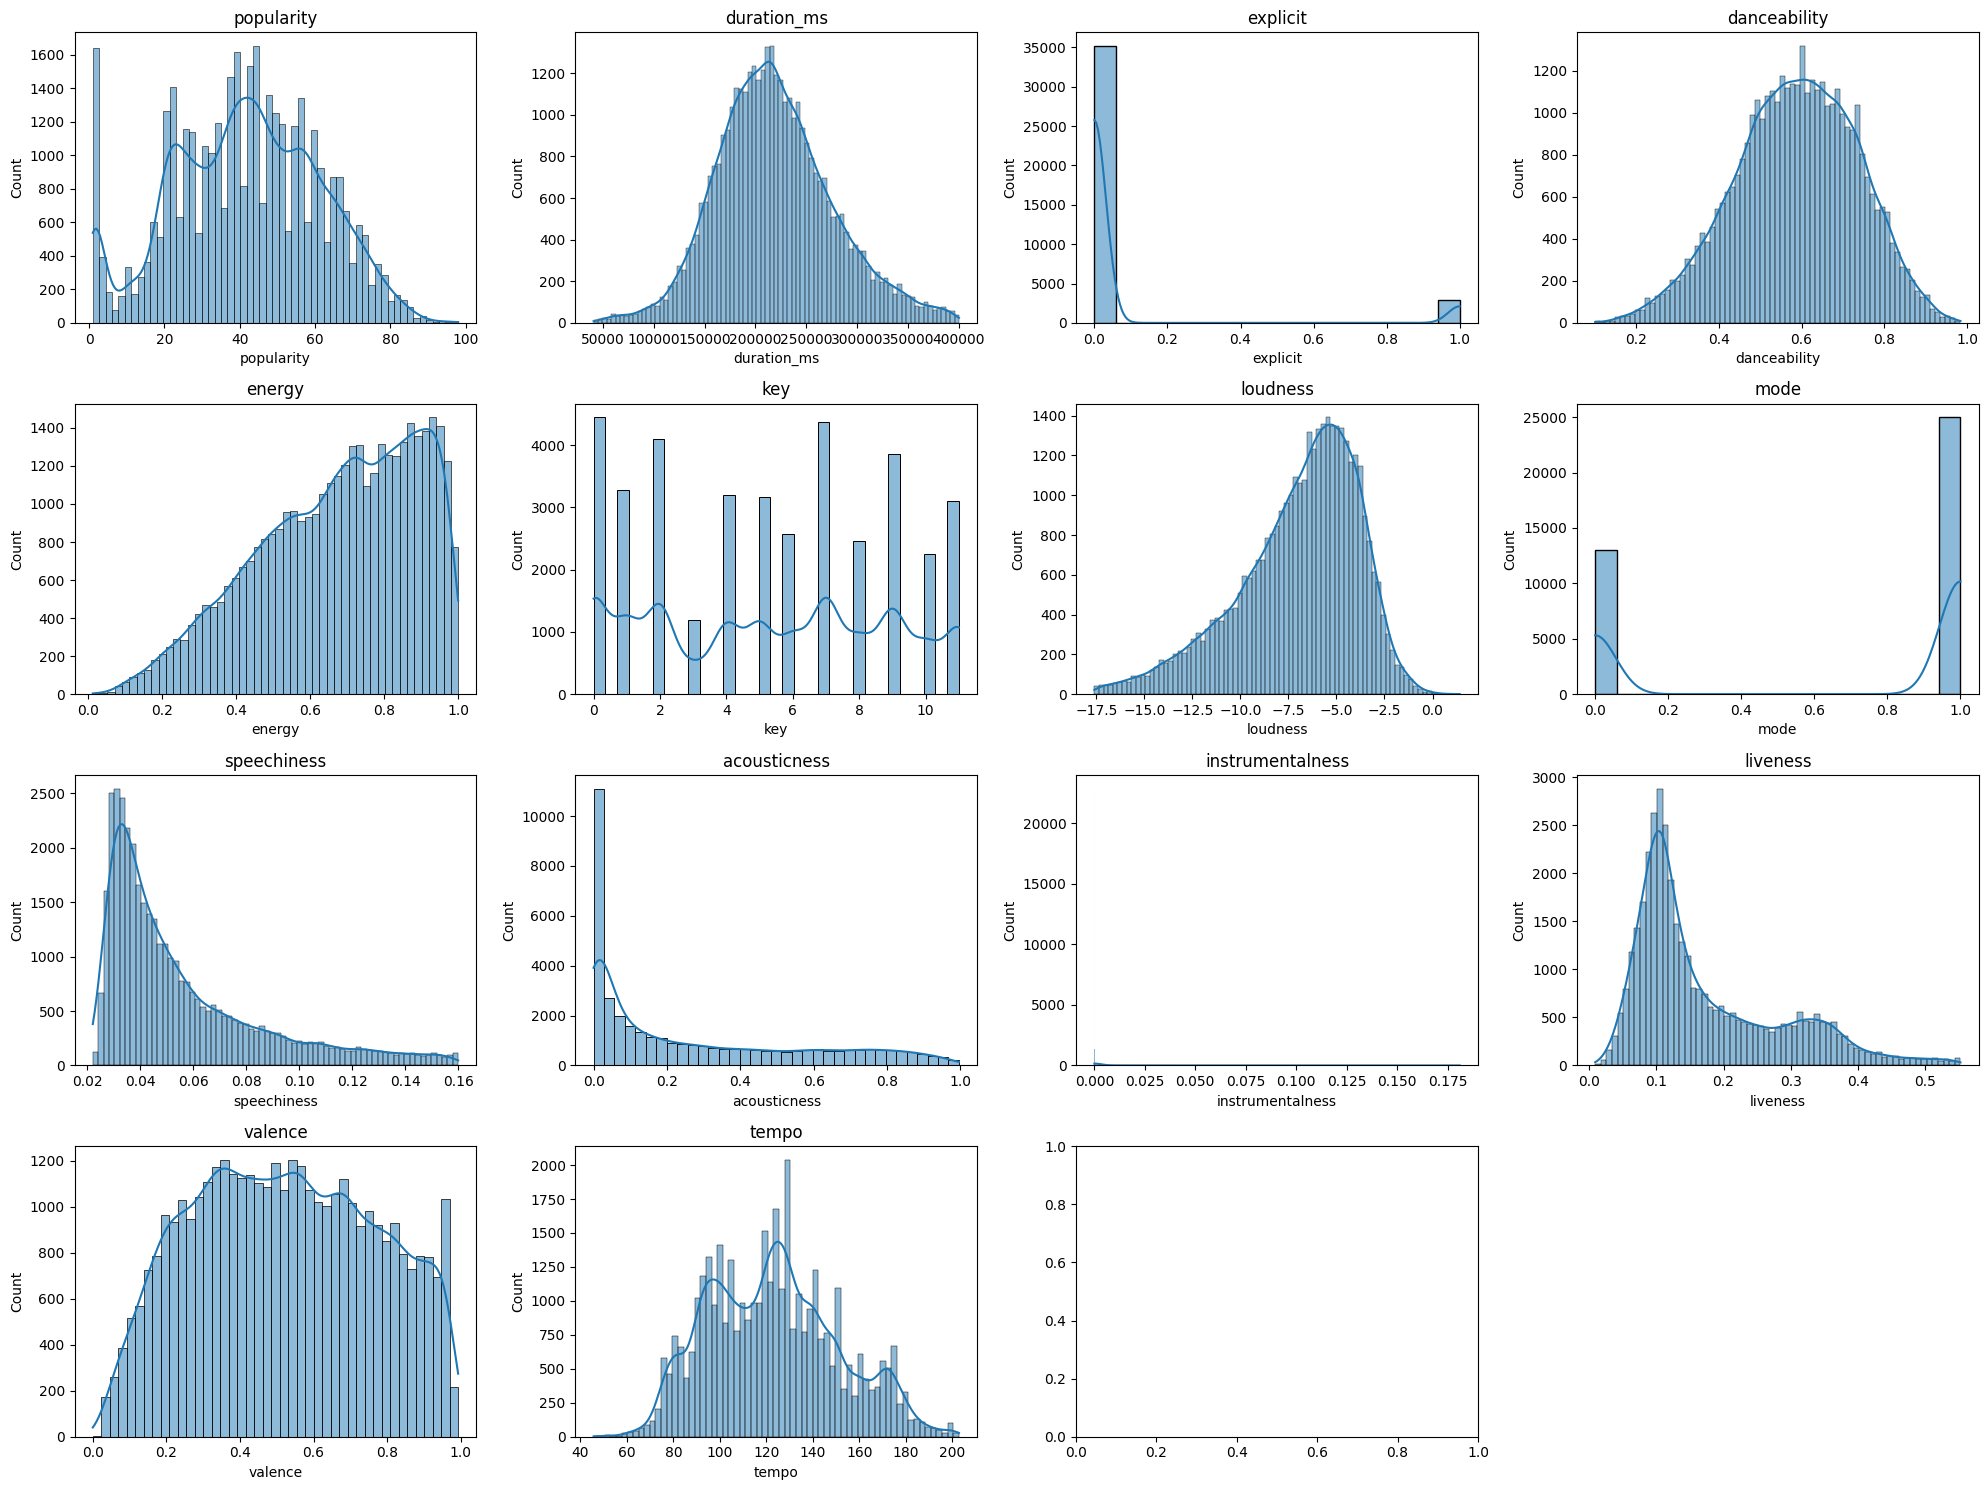

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))
axes = axes.flatten()

# Itera sobre cada coluna das features e mostra um plot delas
for i, column in enumerate(X_train.columns):
    if column != 'time_signature':
        sns.histplot(X_train[column], ax=axes[i], kde=True)
        axes[i].set_title(column)

# Em caso de haver plots que não tem uso, deletaremos eles
for i in range(len(X_train.columns), len(axes)):
    fig.delaxes(axes[i])

# Encaixa os plots um ao lado do outro e exibe eles.
plt.tight_layout()
plt.show()


## Preprocessando os datasets para agilizar no treinamento

In [ ]:
# Escalando os valores de treino e teste
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Testando diferentes modelos com base nos parametros de acurácia, precisão, recall e f1-score.

In [1]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Lista de modelos de classificação
models = [
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Support Vector Machine', SVC()),
    ('Naive Bayes', GaussianNB()),
]

# Armazena métricas sobre os modelos
metrics_results = []

# Itera sobre cada modelo da lista acima
for name, model in models:
    model.fit(X_train_scaled, Y_train)

    Y_pred = model.predict(X_test_scaled)

    # Calcula as métricas de acurácia, precisão, recall e f1
    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred, average='weighted')
    recall = recall_score(Y_test, Y_pred, average='weighted')
    f1 = f1_score(Y_test, Y_pred, average='weighted')

    metrics_results.append([name, accuracy, precision, recall, f1])

    print(f"Classification Report para {name}:")
    print(classification_report(Y_test, Y_pred))
    print("-" * 50)

# Transforma os resultados em um DataFrame
metrics_df = pd.DataFrame(metrics_results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

print(metrics_df)

NameError: name 'linear_model' is not defined

# Testando algoritmos de Regressão

## Criando o DataFrame de features e realizando o split entre dados de treino e test

In [ ]:
features = dataset[['popularity','duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                   'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']]

# Normalizando o dataset de treino e realizando a separação entre dados de teste e dados de treino.
X_train, X_test, Y_train, Y_test = train_test_split(features.drop(['popularity'], axis=1), features['popularity'], random_state=42, test_size=0.25, shuffle=True)

X_train.head()

,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
44600,244613,0.550,0.830,0,-4.467,1,0.0708,0.53000,0.000027,0.2330,0.887,94.693,4
3547,172333,0.578,0.394,7,-11.752,1,0.0271,0.74400,0.000804,0.0943,0.583,84.169,4
16697,202888,0.536,0.894,9,-5.687,1,0.0479,0.00596,0.016800,0.1180,0.784,174.899,4
23444,214765,0.457,0.542,5,-7.645,1,0.0575,0.40800,0.000000,0.1270,0.652,109.973,4
24573,174933,0.746,0.846,9,-2.432,1,0.0480,0.04850,0.000000,0.1950,0.403,114.955,4


## Testando diferentes modelos de regressão para identificar qual é o melhor a ser utilizado.

In [ ]:
# Lista de modelos de regressão
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Random Forest': RandomForestRegressor(),
}

mae_results = {}
r2_results = {}
results = {}

# Itera sobre os modelos
for name, model in models.items():
    # Realiza uma validação cruzada do score com base no modelo e os dados de treino
    cv_scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-cv_scores)

    model.fit(X_train, Y_train)
    predictions = model.predict(X_train)

    # Cálculo de métricas
    mae = mean_absolute_error(Y_train, predictions)
    r2 = r2_score(Y_train, predictions)
    results[name] = rmse_scores
    mae_results[name] = mae
    r2_results[name] = r2

    print(f"{name} - RMSE: {rmse_scores.mean()} -Standart Deviation: {rmse_scores.std()}")
    print(f"{name} - MAE: {mae:.2f} - R²: {r2:.2f}")


Linear Regression - RMSE: 19.218589168280968 -Standart Deviation: 0.11583584728562346
Linear Regression - MAE: 15.42 - R²: 0.03
Ridge - RMSE: 19.218599000777765 -Standart Deviation: 0.11547834441809715
Ridge - MAE: 15.42 - R²: 0.03
Lasso - RMSE: 19.518363200990187 -Standart Deviation: 0.10844181531228722
Lasso - MAE: 15.88 - R²: 0.00
Random Forest - RMSE: 15.33030762900044 -Standart Deviation: 0.15069046848827203
Random Forest - MAE: 4.28 - R²: 0.89


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Decision Tree - RMSE: 21.18020091367096 -Standart Deviation: 0.17107682443586122
Decision Tree - MAE: 0.49 - R²: 0.93


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


KNearest - RMSE: 28.020915179336555 -Standart Deviation: 0.10593523028510987
KNearest - MAE: 14.85 - R²: -0.38


## Com base no output acima, vamos encontrar os hiperparametros necessários para o modelo de Random Forest Regressor.

In [ ]:

from sklearn.model_selection import GridSearchCV

# Definindo os parametros para o modelo de RFR
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, 50, None],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4]
}


rf_model = RandomForestRegressor()

# GridSearchCV para encontrar os melhores parametros e realizar validação cruzada.
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error', n_jobs=-1, verbose=5)

# Realizando o treinamdno
grid_search.fit(X_train, Y_train)

# Melhores parametros encontrados para o modelo
best_params = grid_search.best_params_
print(f'Melhores hiperparametros: {best_params}')

# Melhor modelo
best_model = grid_search.best_estimator_
print(f'Melhor estimator: {best_model}')



Fitting 2 folds for each of 96 candidates, totalling 192 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
96 fits failed out of a total of 192.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
96 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

Best hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


## Realiza uma validação cruzada através do algoritmo KFold, treinando o modelo e fazendo uma predição para encontrar a média MSE.

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = []

for train_index, test_index in kf.split(X_train):
    # Guarda os valores dessas transformações em uma variável temporária para não perder o valor original
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = Y_train.iloc[train_index], Y_train.iloc[test_index]

    best_model.fit(X_train_fold, y_train_fold)
    y_pred = best_model.predict(X_test_fold)

    #MSE
    mse = mean_squared_error(y_test_fold, y_pred)
    mse_scores.append(mse)

#Mean MSE
mean_mse = np.mean(mse_scores)
print(f'Mean MSE: {mean_mse}')

Mean MSE: 233.88772844691508


# Faz uma predição com base em dados fictícios para validar a probabilidade de popularidade de uma música.

In [ ]:
new_data = {
  'duration_ms': 220116,
  'danceability': 0.681,
  'energy':0.788,
  'key': 1,
  'loudness': -4.323,
  'mode': 1,
  'speechiness': 0.0785,
  'acousticness': 0.0482,
  'instrumentalness': 0.0,
  'liveness': 0.0753,
  'valence': 0.839,
  'tempo': 170.019,
  'time_signature': 4,
}
new_data = pd.DataFrame([new_data])


av_model = best_model.predict(new_data)
print(f'The popularity of this song is near: {av_model}')

The popularity of this song is near: [44.23025595]


# Salva o modelo final em um arquivo .pkl para ser utilizado no streamlit

In [ ]:
# Salvando o modelo treinado final.

# Here you can replace pickle with joblib or cloudpickle
from pickle import dump
with open("model.pkl", "wb") as f:
    dump(best_model, f, protocol=5)